In [1]:
!pip install tweet-preprocessor

# 1. Import các thư viện cần thiết

In [2]:
import re
import pickle
import spacy
import string
import random
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt

#import Thư viện model
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, mean_squared_error
from sklearn.model_selection import cross_validate, train_test_split, StratifiedKFold, KFold

#from keras import backend as K
from keras import models
from keras.regularizers import l2
from keras.models import Sequential
from keras.layers import Dense,LSTM, Dropout, Flatten, Embedding, Bidirectional, Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import Adam

from gensim import models
from gensim.models.keyedvectors import KeyedVectors
import tensorflow as tf

import preprocessor as p

import warnings
warnings.filterwarnings("ignore")

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 2. Load data và tiền xử lí dữ liệu

## 2.1. Xây dựng hàm tiền xử lí dữ liệu

In [3]:
#Clean Text
def CleanText(text):
    p.set_options(p.OPT.URL, p.OPT.EMOJI,p.OPT.MENTION)
    ctext = p.clean(text.translate(str.maketrans('', '', string.punctuation))) # this line removes all the punctuations
    return ctext

#delete Stopwords
def Remove_StopWords(text):     
    stopWords = set(stopwords.words('english'))
    words = word_tokenize(text)
    wordsFiltered = []
    for w in words:
        if w not in stopWords:
            wordsFiltered.append(w)
    text = ' '.join(wordsFiltered)
    return text

#Thay Thế từ
def Replace_Words(text):
    replacement_patterns = [
    (r'won\'t', 'will not'),
    (r'can\'t', 'cannot'),
    (r'i\'m', 'i am'),
    (r'ain\'t', 'is not'),
    (r'(\w+)\'ll', '\g<1> will'),
    (r'(\w+)n\'t', '\g<1> not'),
    (r'(\w+)\'ve', '\g<1> have'),
    (r'(\w+)\'s', '\g<1> is'),
    (r'(\w+)\'re', '\g<1> are'),
    (r'(\w+)\'d', '\g<1> would')
    ]
    s = text
    for (pattern, repl) in replacement_patterns:
        s = re.sub(pattern, repl, s)
    return s

## 2.2. Xử lý data Train

In [4]:
name_columns = ['comment','label']

In [5]:
abusive_data ="../input/abusive-language-detection/data/train_abusive.csv"
normal_data ="../input/abusive-language-detection/data/train_nonabusive.csv"

df_abusive = pd.read_csv(abusive_data, usecols=name_columns, sep=',')
df_normal = pd.read_csv(normal_data,usecols=name_columns, sep=',')
df_train = pd.concat([df_abusive, df_normal])

df_train = df_train.drop_duplicates(keep=False)
df_train['word_count'] = df_train['comment'].apply(lambda x: len(str(x).split()))
df_train['char_count'] = len(str(df_train['comment'])) ## this also includes spaces
df_train = df_train[df_train['word_count'] <=75]

#Clean Comment
df_train['comment']=df_train['comment'].apply(Replace_Words)
df_train['comment']=df_train['comment'].apply(CleanText)
df_train['comment']=df_train['comment'].apply(Remove_StopWords)

df_train = df_train.sample(frac=1).reset_index(drop=True)

#gán giá trị non-abusive dựa vào other. Nếu giá trị other = 1 thì Non-abusive và ngược lại
target_names = ['0','1']
class_names = ['Non-abusive', 'Abusive']

yTrain = df_train['label'].values
print(len(yTrain))
print(yTrain)
df_train.head(5)

2301
[0 1 1 ... 1 1 0]


,comment,label,word_count,char_count
0,Stop playing victim getting exposed white supr...,0,11,680
1,Seems like bash Donald Trump I guess SNL bunch...,1,23,680
2,Mr Meadows looks like going go home beat slave...,1,57,680
3,She thought India In India judge would declare...,1,17,680
4,Its always bitch says sum dumb shitt,1,9,680


## 2.3. Xử lý data Test

In [6]:
test_abusive_data ="../input/abusive-language-detection/data/test_abusive.csv"
test_normal_data ="../input/abusive-language-detection/data/test_nonabusive.csv"

df_test_abusive = pd.read_csv(test_abusive_data, usecols=name_columns, sep=',')
df_test_normal = pd.read_csv(test_normal_data,usecols=name_columns, sep=',')
df_test = pd.concat([df_test_abusive, df_test_normal])

df_test = df_test.drop_duplicates(keep=False)
df_test['word_count'] = df_test['comment'].apply(lambda x: len(str(x).split()))
df_test['char_count'] = len(str(df_test['comment'])) ## this also includes spaces
df_test = df_test[df_test['word_count'] <=75]

#Clean Comment
df_test['comment']=df_test['comment'].apply(Replace_Words)
df_test['comment']=df_test['comment'].apply(CleanText)
df_test['comment']=df_test['comment'].apply(Remove_StopWords)

df_test = df_test.sample(frac=1).reset_index(drop=True)

yTest = df_test['label'].values
print(len(yTest))
print(yTest)
df_test.head(5)

1668
[0 1 1 ... 0 0 1]


,comment,label,word_count,char_count
0,I matter religion ethnicity class race We beau...,0,43,669
1,Btw Clintons rape victims mistresses The 12 ye...,1,63,669
2,Im really fed I think Christian brother hell T...,1,48,669
3,Alec impression Trump perfection Regardless wi...,0,44,669
4,There compulsion religion U choose move darkne...,0,36,669


In [7]:
train_text = df_train['comment'].values
test_text = df_test['comment'].values

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfIdfVectorizer=TfidfVectorizer()
tfIdfVectorizer.fit(np.concatenate([train_text, test_text], axis=0))

X_train = tfIdfVectorizer.transform(train_text).toarray()
X_test = tfIdfVectorizer.transform(test_text).toarray()
print(X_train.shape)
print(X_test.shape)

y_train = yTrain
y_test = yTest

(2301, 6328)
(1668, 6328)


# 3. Xây dựng mô hình

# Hàm vẽ đồ thị và lưu mô hình

In [9]:
from sklearn.multiclass import OneVsRestClassifier

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion Matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    
    plt.title(title)
    plt.colorbar()
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label (avg)')
    plt.xlabel('Predicted label (avg)\naccuracy (avg)={:0.4f}; misclass (avg)={:0.4f}'.format(accuracy, misclass))
    plt.grid(None)
    plt.grid(b=None)
    plt.show()

In [10]:
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve

def Plot_ROC(clf,cv,X, y,_title,algoname= ' '):
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots(figsize=(9, 9))
    for i, (train, test) in enumerate(cv.split(X, y)):
        viz = plot_roc_curve(clf, X[test], y[test],
                             name= algoname + 'ROC fold {}'.format(i),
                             alpha=0.3, lw=1, ax=ax)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
            label= algoname + r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           title=_title)
    ax.legend(loc="lower right")
    plt.show()

## 3.1. Logictics Regression

In [11]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report

def LR_Model(X, y,algoname= ' ', _target_names = [], _class_names = []):
    clf = LogisticRegression(random_state=20)
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=20)

    cfmean, accmean, precmean, recmean, f1mean= [], [], [], [], []
    y_test_mean, y_pred_mean = [], []
    tprs, aucs = [], []
    mean_fpr = np.linspace(0, 1, 100)
    fig, ax = plt.subplots(figsize=(9, 9))
    
    for i, (train_index, test_index) in enumerate(kfold.split(X, y)):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        
        y_test_mean.append(y_test)
        y_pred_mean.append(y_pred)
        
        viz = plot_roc_curve(clf, X_test, y_test,
                             name= algoname + 'ROC fold {}'.format(i),
                             alpha=0.3, lw=1, ax=ax)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

        print("*********************** Iteration: " + str(i+1) + " ***********************")
        
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        accmean.append(accuracy)
        precmean.append(precision)
        recmean.append(recall)
        f1mean.append(f1)
        
        print("=== Scores ===")
        print('Accuracy: %f' % accuracy) 
        print('Precision: %f' % precision)
        print('Recall: %f' % recall)
        print('F1 score: %f' % f1)
        
        print("=== Classification Report ===")
        target_names = _target_names
        print(classification_report(y_test, y_pred, target_names=target_names))
        
        print("=== Confusion Matrix ===")
        print(confusion_matrix(y_test, y_pred))
        cfmean.append(confusion_matrix(y_test, y_pred))
  
        print('\n')
                
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
            label= algoname + r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], title="")
    ax.legend(loc="lower right")
    plt.show()
    
    acc = np.mean(accmean, axis=0)
    pre = np.mean(precmean, axis=0)
    cm = np.mean(cfmean, axis=0)
    re = np.mean(recmean, axis=0)
    f1 = np.mean(f1mean, axis=0)
    
    print('\n')
    print("Averages")
    print("Accuracy: " + str(acc))
    print("Precision: " + str(pre))
    print("Recall: " + str(re))
    print("F1 measure: " + str(f1))
    print('Confusion Matrix\n')
    print(cm)
    
    #plot graph
    class_names = _class_names
    plot_confusion_matrix(cm, target_names=class_names,title='')
    plt.show()
        
    return clf, acc, pre, re, f1

In [12]:
dict_model = {}

*********************** Iteration: 1 ***********************
=== Scores ===
Accuracy: 0.848485
Precision: 0.909091
Recall: 0.775862
F1 score: 0.837209
=== Classification Report ===
              precision    recall  f1-score   support

           0       0.80      0.92      0.86       115
           1       0.91      0.78      0.84       116

    accuracy                           0.85       231
   macro avg       0.86      0.85      0.85       231
weighted avg       0.86      0.85      0.85       231

=== Confusion Matrix ===
[[106   9]
 [ 26  90]]


*********************** Iteration: 2 ***********************
=== Scores ===
Accuracy: 0.800000
Precision: 0.925926
Recall: 0.652174
F1 score: 0.765306
=== Classification Report ===
              precision    recall  f1-score   support

           0       0.73      0.95      0.83       115
           1       0.93      0.65      0.77       115

    accuracy                           0.80       230
   macro avg       0.83      0.80      0.80

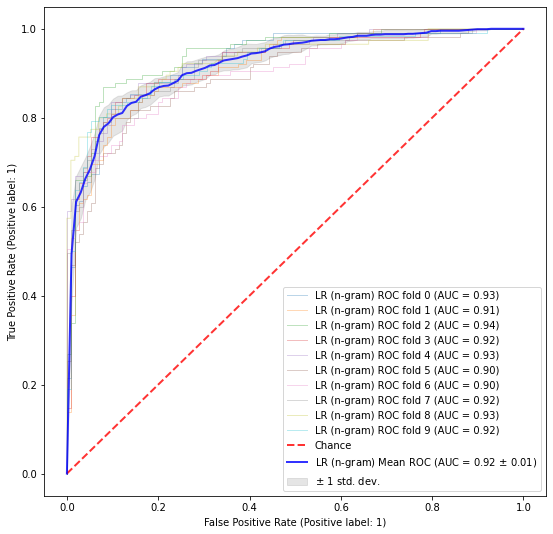



Averages
Accuracy: 0.8409354413702239
Precision: 0.912282095370235
Recall: 0.7551574212893553
F1 measure: 0.8256603943175967
Confusion Matrix

[[106.5   8.4]
 [ 28.2  87. ]]


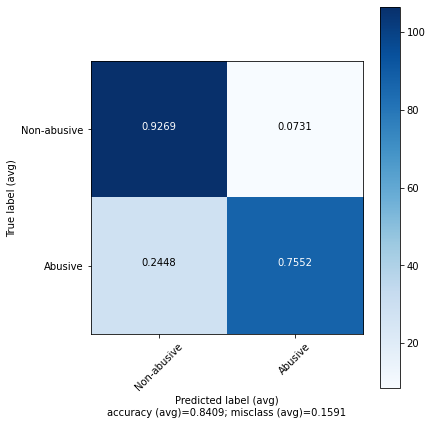

In [13]:
dict_model['Logictics Regression'] = LR_Model(X_train, y_train,'LR (n-gram) ', target_names, class_names)

## 3.2. MLP model

In [14]:
def MLP_Model(X, y,algoname= ' ', _target_names = [], _class_names = []):
    clf = MLPClassifier(random_state=20)
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=20)

    cfmean, accmean, precmean, recmean, f1mean= [], [], [], [], []
    y_test_mean, y_pred_mean = [], []
    tprs, aucs = [], []
    mean_fpr = np.linspace(0, 1, 100)
    fig, ax = plt.subplots(figsize=(9, 9))
    
    for i, (train_index, test_index) in enumerate(kfold.split(X, y)):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        
        y_test_mean.append(y_test)
        y_pred_mean.append(y_pred)
        
        viz = plot_roc_curve(clf, X_test, y_test,
                             name= algoname + 'ROC fold {}'.format(i),
                             alpha=0.3, lw=1, ax=ax)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)
        
        print("*********************** Iteration: " + str(i+1) + " ***********************")

        accuracy = accuracy_score(y_test, y_pred)        
        precision = precision_score(y_test, y_pred)        
        recall = recall_score(y_test, y_pred)        
        f1 = f1_score(y_test, y_pred)

        print("=== Scores ===")
        print('Accuracy: %f' % accuracy)
        print('Precision: %f' % precision)
        print('Recall: %f' % recall)
        print('F1 score: %f' % f1)
                        
        accmean.append(accuracy)
        precmean.append(precision)
        recmean.append(recall)
        f1mean.append(f1)

        print("=== Classification Report ===")
        target_names = _target_names
        print(classification_report(y_test, y_pred, target_names=target_names))
        
        print("=== Confusion Matrix ===")
        print(confusion_matrix(y_test, y_pred))
        cfmean.append(confusion_matrix(y_test, y_pred))
  
        print('\n')
    
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
            label= algoname + r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           title="")
    ax.legend(loc="lower right")
    plt.show()
    
    acc = np.mean(accmean, axis=0)
    pre = np.mean(precmean, axis=0)
    cm = np.mean(cfmean, axis=0)
    re = np.mean(recmean, axis=0)
    f1 = np.mean(f1mean, axis=0)
    
    print('\n')
    print("Averages")
    print("Accuracy: " + str(acc))
    print("Precision: " + str(pre))
    print("Recall: " + str(re))
    print("F1 measure: " + str(f1))
    print('Confusion Matrix\n')
    print(cm)
    
    #plot graph
    class_names = _class_names
    plot_confusion_matrix(cm, target_names=class_names,title='')
    plt.show()
    
    return clf, acc, pre, re, f1

*********************** Iteration: 1 ***********************
=== Scores ===
Accuracy: 0.818182
Precision: 0.813559
Recall: 0.827586
F1 score: 0.820513
=== Classification Report ===
              precision    recall  f1-score   support

           0       0.82      0.81      0.82       115
           1       0.81      0.83      0.82       116

    accuracy                           0.82       231
   macro avg       0.82      0.82      0.82       231
weighted avg       0.82      0.82      0.82       231

=== Confusion Matrix ===
[[93 22]
 [20 96]]


*********************** Iteration: 2 ***********************
=== Scores ===
Accuracy: 0.782609
Precision: 0.815534
Recall: 0.730435
F1 score: 0.770642
=== Classification Report ===
              precision    recall  f1-score   support

           0       0.76      0.83      0.79       115
           1       0.82      0.73      0.77       115

    accuracy                           0.78       230
   macro avg       0.79      0.78      0.78    

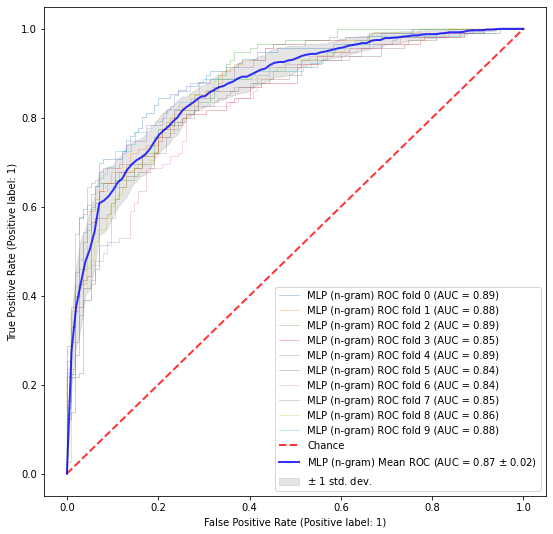



Averages
Accuracy: 0.7796442687747036
Precision: 0.7890518403318169
Recall: 0.7646851574212893
F1 measure: 0.776277465614258
Confusion Matrix

[[91.3 23.6]
 [27.1 88.1]]


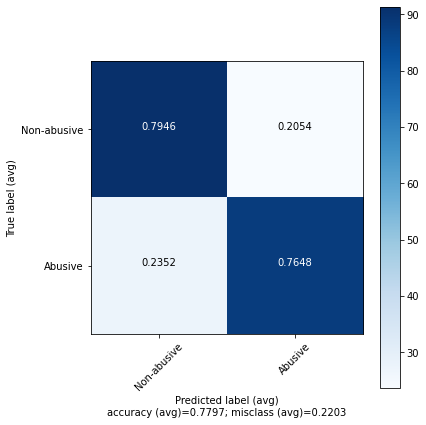

In [15]:
dict_model['MLP model'] = MLP_Model(X_train, y_train,'MLP (n-gram) ', target_names, class_names)

## 3.3. AdaBoost model

In [16]:
def AB_Model(X, y,algoname= ' ', _target_names = [], _class_names = []):  
    clf = AdaBoostClassifier(random_state=20)
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=20)

    cfmean, accmean, precmean, recmean, f1mean= [], [], [], [], []
    y_test_mean, y_pred_mean = [], []
    tprs, aucs = [], []
    mean_fpr = np.linspace(0, 1, 100)
    fig, ax = plt.subplots(figsize=(9, 9))
    
    for i, (train_index, test_index) in enumerate(kfold.split(X, y)):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        
        y_test_mean.append(y_test)
        y_pred_mean.append(y_pred)
        
        viz = plot_roc_curve(clf, X_test, y_test,
                             name= algoname + 'ROC fold {}'.format(i),
                             alpha=0.3, lw=1, ax=ax)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

        print("*********************** Iteration: " + str(i+1) + " ***********************")
                
        accuracy = accuracy_score(y_test, y_pred)        
        precision = precision_score(y_test, y_pred)        
        recall = recall_score(y_test, y_pred)        
        f1 = f1_score(y_test, y_pred)
        
        print("=== Scores ===")
        print('Accuracy: %f' % accuracy)
        print('Precision: %f' % precision)
        print('Recall: %f' % recall)
        print('F1 score: %f' % f1)
        
        accmean.append(accuracy)
        precmean.append(precision)
        recmean.append(recall)
        f1mean.append(f1)
    
        print("=== Classification Report ===")
        target_names = _target_names
        print(classification_report(y_test, y_pred, target_names=target_names))
        
        print("=== Confusion Matrix ===")
        print(confusion_matrix(y_test, y_pred))
        cfmean.append(confusion_matrix(y_test, y_pred))
  
        print('\n')
        
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
            label= algoname + r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           title="")
    ax.legend(loc="lower right")
    plt.show()
    
    acc = np.mean(accmean, axis=0)
    pre = np.mean(precmean, axis=0)
    cm = np.mean(cfmean, axis=0)
    re = np.mean(recmean, axis=0)
    f1 = np.mean(f1mean, axis=0)
    
    print('\n')
    print("Averages")
    print("Accuracy: " + str(acc))
    print("Precision: " + str(pre))
    print("Recall: " + str(re))
    print("F1 measure: " + str(f1))
    print('Confusion Matrix\n')
    print(cm)
    
    #plot graph
    class_names = _class_names
    plot_confusion_matrix(cm, target_names=class_names,title='')
    plt.show()
    
    return clf, acc, pre, re, f1
    

*********************** Iteration: 1 ***********************
=== Scores ===
Accuracy: 0.874459
Precision: 0.978022
Recall: 0.767241
F1 score: 0.859903
=== Classification Report ===
              precision    recall  f1-score   support

           0       0.81      0.98      0.89       115
           1       0.98      0.77      0.86       116

    accuracy                           0.87       231
   macro avg       0.89      0.87      0.87       231
weighted avg       0.89      0.87      0.87       231

=== Confusion Matrix ===
[[113   2]
 [ 27  89]]


*********************** Iteration: 2 ***********************
=== Scores ===
Accuracy: 0.856522
Precision: 0.927083
Recall: 0.773913
F1 score: 0.843602
=== Classification Report ===
              precision    recall  f1-score   support

           0       0.81      0.94      0.87       115
           1       0.93      0.77      0.84       115

    accuracy                           0.86       230
   macro avg       0.87      0.86      0.86

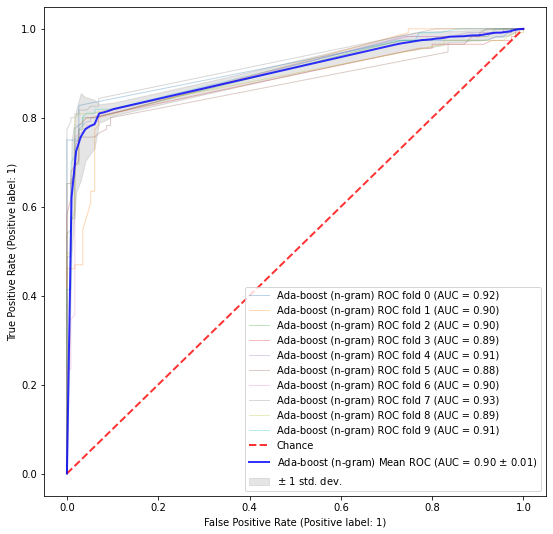



Averages
Accuracy: 0.8722284961415397
Precision: 0.9418683577590036
Recall: 0.7942728635682158
F1 measure: 0.8616088070225498
Confusion Matrix

[[109.2   5.7]
 [ 23.7  91.5]]


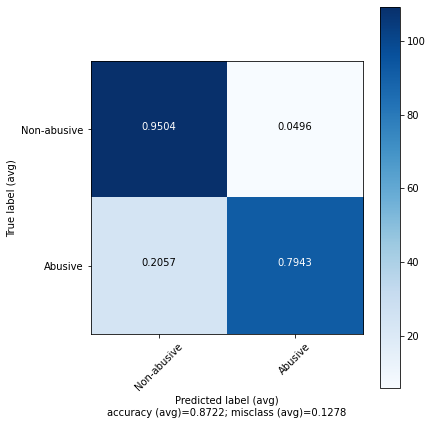

In [17]:
dict_model['AdaBoost model'] = AB_Model(X_train, y_train,'Ada-boost (n-gram) ', target_names, class_names)

## 3.4. Random forest model

In [18]:
def RF_Model(X, y,algoname= ' ', _target_names = [], _class_names = []):
    clf = RandomForestClassifier(random_state=20)
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=20)

    cfmean, accmean, precmean, recmean, f1mean= [], [], [], [], []
    y_test_mean, y_pred_mean = [], []
    tprs, aucs = [], []
    mean_fpr = np.linspace(0, 1, 100)
    fig, ax = plt.subplots(figsize=(9, 9))
    
    for i, (train_index, test_index) in enumerate(kfold.split(X, y)):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        
        y_test_mean.append(y_test)
        y_pred_mean.append(y_pred)
        
        viz = plot_roc_curve(clf, X_test, y_test,
                             name= algoname + 'ROC fold {}'.format(i),
                             alpha=0.3, lw=1, ax=ax)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

        print("*********************** Iteration: " + str(i+1) + " ***********************")
        
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        print("=== Scores ===")
        print('Accuracy: %f' % accuracy)
        print('Precision: %f' % precision)
        print('Recall: %f' % recall)
        print('F1 score: %f' % f1)
        
        accmean.append(accuracy)
        precmean.append(precision)
        recmean.append(recall)
        f1mean.append(f1)
        
        print("=== Classification Report ===")
        target_names = _target_names
        print(classification_report(y_test, y_pred, target_names=target_names))
        
        print("=== Confusion Matrix ===")
        print(confusion_matrix(y_test, y_pred))
        cfmean.append(confusion_matrix(y_test, y_pred))
  
        print('\n')
        
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
            label= algoname + r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           title="")
    ax.legend(loc="lower right")
    plt.show()
    
    acc = np.mean(accmean, axis=0)
    pre = np.mean(precmean, axis=0)
    cm = np.mean(cfmean, axis=0)
    re = np.mean(recmean, axis=0)
    f1 = np.mean(f1mean, axis=0)
    
    print('\n')
    print("Averages")
    print("Accuracy: " + str(acc))
    print("Precision: " + str(pre))
    print("Recall: " + str(re))
    print("F1 measure: " + str(f1))
    print('Confusion Matrix\n')
    print(cm)
    
    #plot graph
    class_names = _class_names
    plot_confusion_matrix(cm, target_names=class_names,title='')
    plt.show()
    
    return clf, acc, pre, re, f1

*********************** Iteration: 1 ***********************
=== Scores ===
Accuracy: 0.861472
Precision: 0.920000
Recall: 0.793103
F1 score: 0.851852
=== Classification Report ===
              precision    recall  f1-score   support

           0       0.82      0.93      0.87       115
           1       0.92      0.79      0.85       116

    accuracy                           0.86       231
   macro avg       0.87      0.86      0.86       231
weighted avg       0.87      0.86      0.86       231

=== Confusion Matrix ===
[[107   8]
 [ 24  92]]


*********************** Iteration: 2 ***********************
=== Scores ===
Accuracy: 0.834783
Precision: 0.952941
Recall: 0.704348
F1 score: 0.810000
=== Classification Report ===
              precision    recall  f1-score   support

           0       0.77      0.97      0.85       115
           1       0.95      0.70      0.81       115

    accuracy                           0.83       230
   macro avg       0.86      0.83      0.83

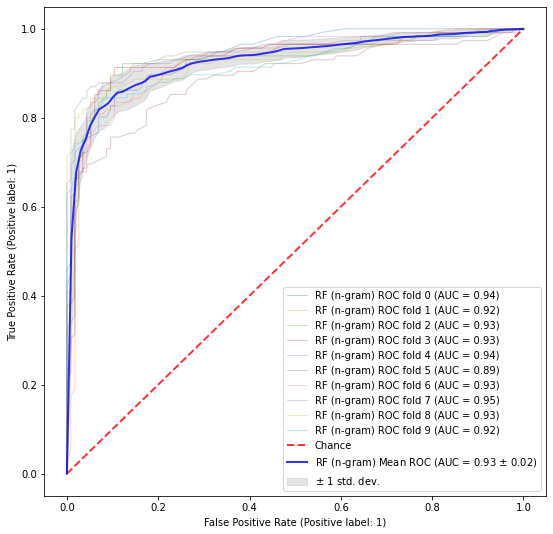



Averages
Accuracy: 0.8678863165819687
Precision: 0.9363789755190206
Recall: 0.7899100449775112
F1 measure: 0.8562905828256795
Confusion Matrix

[[108.7   6.2]
 [ 24.2  91. ]]


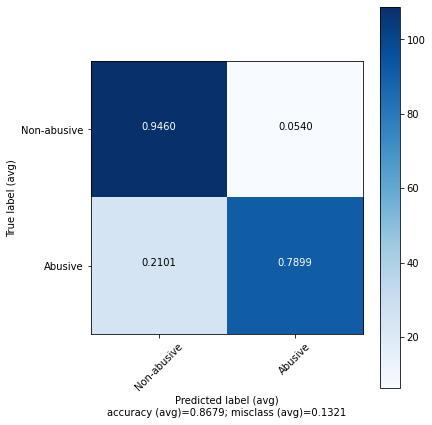

In [19]:
dict_model['Random forest model'] = RF_Model(X_train, y_train,'RF (n-gram) ', target_names, class_names)

## 3.5. SVM model

In [20]:
from sklearn.svm import SVC

def SVM_Model(X, y,algoname= ' ', _target_names = [], _class_names = []):
    clf = SVC(probability=True,class_weight='balanced', random_state=20)
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=20)

    cfmean, accmean, precmean, recmean, f1mean= [], [], [], [], []
    y_test_mean, y_pred_mean = [], []
    tprs, aucs = [], []
    mean_fpr = np.linspace(0, 1, 100)
    fig, ax = plt.subplots(figsize=(9, 9))
    
    for i, (train_index, test_index) in enumerate(kfold.split(X, y)):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        
        y_test_mean.append(y_test)
        y_pred_mean.append(y_pred)
        
        viz = plot_roc_curve(clf, X_test, y_test,
                             name= algoname + 'ROC fold {}'.format(i),
                             alpha=0.3, lw=1, ax=ax)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

        print("*********************** Iteration: " + str(i+1) + " ***********************")
        
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        
        print("=== Scores ===")        
        print('Accuracy: %f' % accuracy)        
        print('Precision: %f' % precision)        
        print('Recall: %f' % recall)        
        print('F1 score: %f' % f1)
        
        accmean.append(accuracy)
        precmean.append(precision)
        recmean.append(recall)
        f1mean.append(f1)
        
        print("=== Classification Report ===")
        target_names = _target_names
        print(classification_report(y_test, y_pred, target_names=target_names))
        
        print("=== Confusion Matrix ===")
        print(confusion_matrix(y_test, y_pred))
        cfmean.append(confusion_matrix(y_test, y_pred))
  
        print('\n')
        
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
            label= algoname + r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           title="")
    ax.legend(loc="lower right")
    plt.show()
    
    acc = np.mean(accmean, axis=0)
    pre = np.mean(precmean, axis=0)
    cm = np.mean(cfmean, axis=0)
    re = np.mean(recmean, axis=0)
    f1 = np.mean(f1mean, axis=0)
    
    print('\n')
    print("Averages")
    print("Accuracy: " + str(acc))
    print("Precision: " + str(pre))
    print("Recall: " + str(re))
    print("F1 measure: " + str(f1))
    print('Confusion Matrix\n')
    print(cm)
    
    #plot graph
    class_names = _class_names
    plot_confusion_matrix(cm, target_names=class_names,title='')
    plt.show()
    
    return clf, acc, pre, re, f1

*********************** Iteration: 1 ***********************
=== Scores ===
Accuracy: 0.835498
Precision: 0.897959
Recall: 0.758621
F1 score: 0.822430
=== Classification Report ===
              precision    recall  f1-score   support

           0       0.79      0.91      0.85       115
           1       0.90      0.76      0.82       116

    accuracy                           0.84       231
   macro avg       0.84      0.84      0.83       231
weighted avg       0.84      0.84      0.83       231

=== Confusion Matrix ===
[[105  10]
 [ 28  88]]


*********************** Iteration: 2 ***********************
=== Scores ===
Accuracy: 0.804348
Precision: 0.948718
Recall: 0.643478
F1 score: 0.766839
=== Classification Report ===
              precision    recall  f1-score   support

           0       0.73      0.97      0.83       115
           1       0.95      0.64      0.77       115

    accuracy                           0.80       230
   macro avg       0.84      0.80      0.80

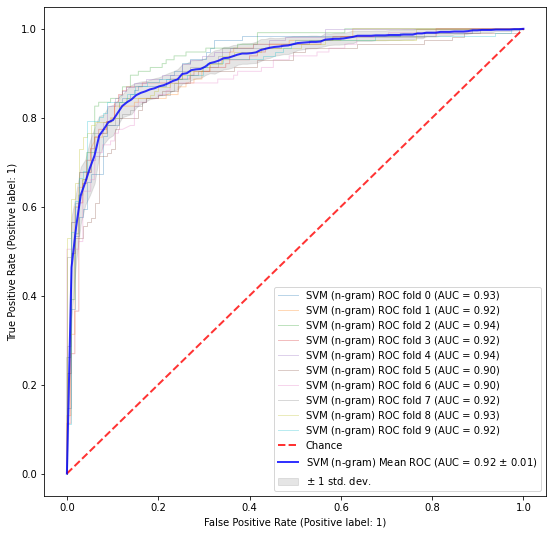



Averages
Accuracy: 0.8409410878976097
Precision: 0.9240069969064493
Recall: 0.7438905547226388
F1 measure: 0.8234355152424385
Confusion Matrix

[[107.8   7.1]
 [ 29.5  85.7]]


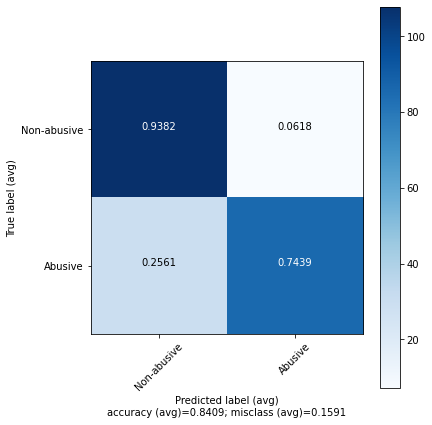

In [21]:
dict_model['SVM model'] = SVM_Model(X_train, y_train,'SVM (n-gram) ', target_names, class_names)

## 3.6. Gaussian NB model:

In [22]:
from sklearn.naive_bayes import GaussianNB

def NB_Model(X, y,algoname= ' ', _target_names = [], _class_names = []):
    clf = GaussianNB()
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=20)

    cfmean, accmean, precmean, recmean, f1mean= [], [], [], [], []
    y_test_mean, y_pred_mean = [], []
    tprs, aucs = [], []
    mean_fpr = np.linspace(0, 1, 100)
    fig, ax = plt.subplots(figsize=(9, 9))

    for i, (train_index, test_index) in enumerate(kfold.split(X, y)):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        
        y_test_mean.append(y_test)
        y_pred_mean.append(y_pred)
        
        
        viz = plot_roc_curve(clf, X_test, y_test,
                             name= algoname + 'ROC fold {}'.format(i),
                             alpha=0.3, lw=1, ax=ax)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)
           
        print("*********************** Iteration: " + str(i+1) + " ***********************")
        
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        print("=== Scores ===")
        print('Accuracy: %f' % accuracy)
        print('Precision: %f' % precision)        
        print('Recall: %f' % recall)        
        print('F1 score: %f' % f1)
        
        accmean.append(accuracy)
        precmean.append(precision)
        recmean.append(recall)
        f1mean.append(f1)
        
        print("=== Classification Report ===")
        target_names = _target_names
        print(classification_report(y_test, y_pred, target_names=target_names))
        
        print("=== Confusion Matrix ===")
        print(confusion_matrix(y_test, y_pred))
        cfmean.append(confusion_matrix(y_test, y_pred))
  
        print('\n')
    
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
            label= algoname + r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           title="")
    ax.legend(loc="lower right")
    plt.show()
    
    acc = np.mean(accmean, axis=0)
    pre = np.mean(precmean, axis=0)
    cm = np.mean(cfmean, axis=0)
    re = np.mean(recmean, axis=0)
    f1 = np.mean(f1mean, axis=0)
    
    print('\n')
    print("Averages")
    print("Accuracy: " + str(acc))
    print("Precision: " + str(pre))
    print("Recall: " + str(re))
    print("F1 measure: " + str(f1))
    print('Confusion Matrix\n')
    print(cm)
    
    #plot graph
    class_names = _class_names
    plot_confusion_matrix(cm, target_names=class_names,title='')
    plt.show()
    
    return clf, acc, pre, re, f1

*********************** Iteration: 1 ***********************
=== Scores ===
Accuracy: 0.653680
Precision: 0.663636
Recall: 0.629310
F1 score: 0.646018
=== Classification Report ===
              precision    recall  f1-score   support

           0       0.64      0.68      0.66       115
           1       0.66      0.63      0.65       116

    accuracy                           0.65       231
   macro avg       0.65      0.65      0.65       231
weighted avg       0.65      0.65      0.65       231

=== Confusion Matrix ===
[[78 37]
 [43 73]]


*********************** Iteration: 2 ***********************
=== Scores ===
Accuracy: 0.734783
Precision: 0.764706
Recall: 0.678261
F1 score: 0.718894
=== Classification Report ===
              precision    recall  f1-score   support

           0       0.71      0.79      0.75       115
           1       0.76      0.68      0.72       115

    accuracy                           0.73       230
   macro avg       0.74      0.73      0.73    

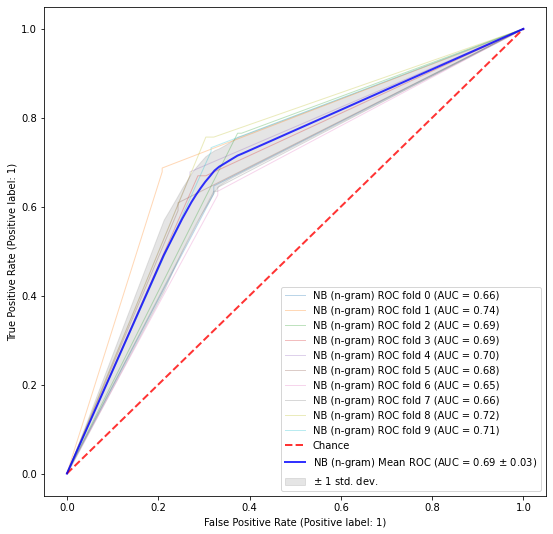



Averages
Accuracy: 0.6879766610201392
Precision: 0.6946893158828991
Recall: 0.6744752623688156
F1 measure: 0.6831781762565394
Confusion Matrix

[[80.6 34.3]
 [37.5 77.7]]


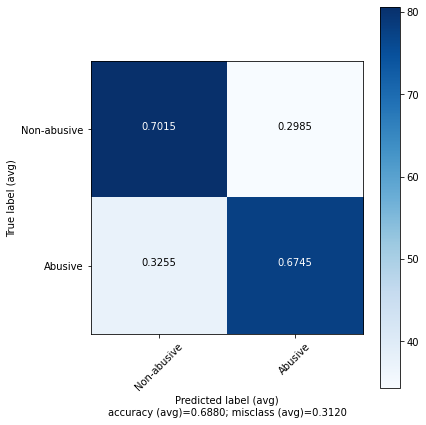

In [23]:
dict_model['Gaussian NB model'] = NB_Model(X_train, y_train,'NB (n-gram) ', target_names, class_names)

## 3.7 Decision Tree Model

In [24]:
def DT_Model(X, y,algoname= ' ', _target_names = [], _class_names = []):
    clf = DecisionTreeClassifier(random_state=20)
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=20)
    
    cfmean, accmean, precmean, recmean, f1mean= [], [], [], [], []
    y_test_mean, y_pred_mean = [], []
    tprs, aucs = [], []
    
    mean_fpr = np.linspace(0, 1, 100)
    fig, ax = plt.subplots(figsize=(9, 9))
    
    count = 1
    for i, (train_index, test_index) in enumerate(kfold.split(X, y)):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        
        y_test_mean.append(y_test)
        y_pred_mean.append(y_pred)
        
        
        viz = plot_roc_curve(clf, X_test, y_test,
                             name= algoname + 'ROC fold {}'.format(i),
                             alpha=0.3, lw=1, ax=ax)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

        print("*********************** Iteration: " + str(i+1) + " ***********************")
        
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred) 
        f1 = f1_score(y_test, y_pred)
        
        print("=== Scores ===")
        print('Accuracy: %f' % accuracy)
        print('Precision: %f' % precision)
        print('Recall: %f' % recall)
        print('F1 score: %f' % f1)
        
        accmean.append(accuracy)
        precmean.append(precision)
        recmean.append(recall)
        f1mean.append(f1)
        
        print("=== Classification Report ===")
        target_names = _target_names
        print(classification_report(y_test, y_pred, target_names=target_names))
        
        print("=== Confusion Matrix ===")
        print(confusion_matrix(y_test, y_pred))
        cfmean.append(confusion_matrix(y_test, y_pred))
  
        print('\n')
        count = count + 1
        
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
            label= algoname + r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           title="")
    ax.legend(loc="lower right")
    plt.show()
    
    acc = np.mean(accmean, axis=0)
    pre = np.mean(precmean, axis=0)
    cm = np.mean(cfmean, axis=0)
    re = np.mean(recmean, axis=0)
    f1 = np.mean(f1mean, axis=0)
    
    print('\n')
    print("Averages")
    print("Accuracy: " + str(acc))
    print("Precision: " + str(pre))
    print("Recall: " + str(re))
    print("F1 measure: " + str(f1))
    print('Confusion Matrix\n')
    print(cm)
    
    #plot graph
    class_names = _class_names
    plot_confusion_matrix(cm, target_names=class_names,title='')
    plt.show()
    
    return clf, acc, pre, re, f1

*********************** Iteration: 1 ***********************
=== Scores ===
Accuracy: 0.878788
Precision: 0.879310
Recall: 0.879310
F1 score: 0.879310
=== Classification Report ===
              precision    recall  f1-score   support

           0       0.88      0.88      0.88       115
           1       0.88      0.88      0.88       116

    accuracy                           0.88       231
   macro avg       0.88      0.88      0.88       231
weighted avg       0.88      0.88      0.88       231

=== Confusion Matrix ===
[[101  14]
 [ 14 102]]


*********************** Iteration: 2 ***********************
=== Scores ===
Accuracy: 0.886957
Precision: 0.900901
Recall: 0.869565
F1 score: 0.884956
=== Classification Report ===
              precision    recall  f1-score   support

           0       0.87      0.90      0.89       115
           1       0.90      0.87      0.88       115

    accuracy                           0.89       230
   macro avg       0.89      0.89      0.89

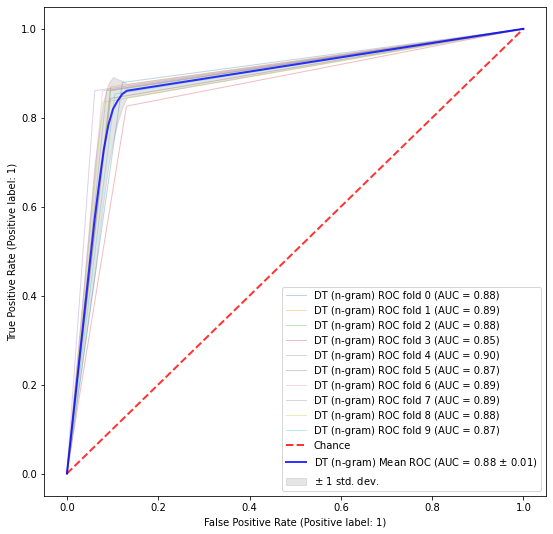



Averages
Accuracy: 0.8800527009222661
Precision: 0.9007059175242158
Recall: 0.855014992503748
F1 measure: 0.8771388217117748
Confusion Matrix

[[104.   10.9]
 [ 16.7  98.5]]


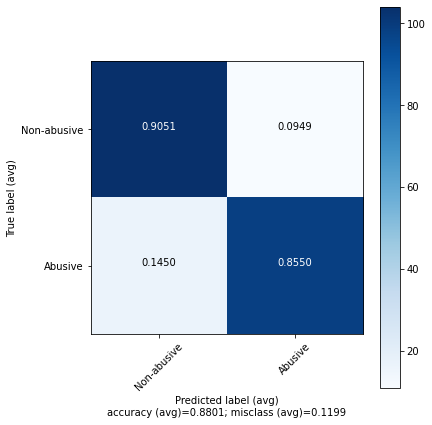

In [25]:
dict_model['Decision Tree Model'] = DT_Model(X_train, y_train,'DT (n-gram) ', target_names, class_names)

# 4. Test kết quả

In [26]:
for model_name, model in dict_model.items():
    print("\n===============", model_name, '===============\n')
    y_pred = model[0].predict(X_test)
    print(classification_report(y_pred, y_test))


=============== Logictics Regression ===============

              precision    recall  f1-score   support

           0       0.97      0.93      0.95       874
           1       0.93      0.97      0.95       794

    accuracy                           0.95      1668
   macro avg       0.95      0.95      0.95      1668
weighted avg       0.95      0.95      0.95      1668


=============== MLP model ===============

              precision    recall  f1-score   support

           0       0.97      0.98      0.97       829
           1       0.98      0.97      0.97       839

    accuracy                           0.97      1668
   macro avg       0.97      0.97      0.97      1668
weighted avg       0.97      0.97      0.97      1668


=============== AdaBoost model ===============

              precision    recall  f1-score   support

           0       0.96      0.84      0.90       948
           1       0.82      0.95      0.88       720

    accuracy                      

# 5. Vẽ biểu đồ so sánh giữa các mô hình

In [27]:
model_ = []
for model_name, model in dict_model.items():
    model_.append([model_name] + list(model[1:]))
    
df_model = pd.DataFrame(model_, columns=['Model', 'accuracy', 'precision', 'recall', 'f1-score'])
df_model = df_model.set_index('Model', drop= True)
df_model

,accuracy,precision,recall,f1-score
Model,,,,
Logictics Regression,0.840935,0.912282,0.755157,0.825660
MLP model,0.779644,0.789052,0.764685,0.776277
AdaBoost model,0.872228,0.941868,0.794273,0.861609
Random forest model,0.867886,0.936379,0.789910,0.856291
SVM model,0.840941,0.924007,0.743891,0.823436
Gaussian NB model,0.687977,0.694689,0.674475,0.683178
Decision Tree Model,0.880053,0.900706,0.855015,0.877139


<AxesSubplot:xlabel='Model'>

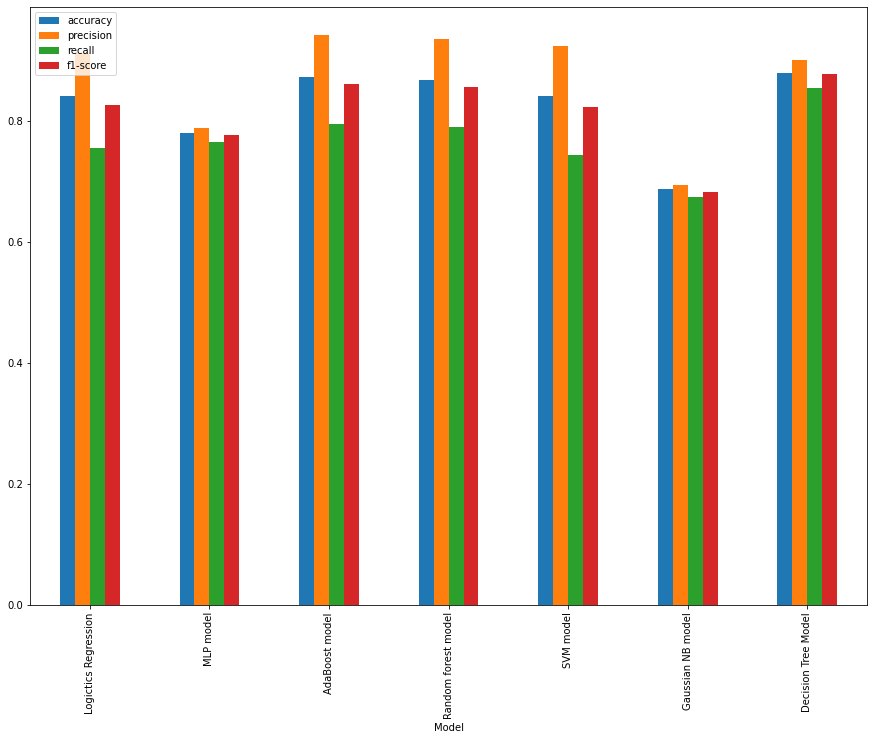

In [31]:
df_model.plot( kind="bar", figsize=(15,11))